# Exercise 1

In this exercise, starting from the cleaned and pre-pricessed dataset in the notebook 'Ex1-Preprocess.ipynb', 'data/clean_data.csv' we train a Random-Forest Classifier that given a soccer player description outputs his skin color.

In [1]:
# basic imports
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

### Cleaned Data importing
we start first by importing and investigating the data.

In [2]:
# reading the data
data = pd.read_csv("data/clean_data.csv", sep=',')
data = data.replace([np.inf, -np.inf], np.nan).dropna()
print("data shape = ")
print(data.shape)
# Display the first 10 rows of the dataset. Only 13 columns for space reasons
print("Fist 13 columns :")
data.ix[:10,:13]

data shape = 
(1564, 19)
Fist 13 columns :


,Unnamed: 0,playerShort,yellowReds,goals,birthday,ties,leagueCountry,black,defeats,weight,victories,height,meanExp
0,0,0,0,9,08.11.1979,179,0,0,228,71.0,247,182.0,0.494575
1,1,1,0,62,04.09.1986,73,2,0,122,73.0,141,183.0,0.449220
2,2,2,0,31,16.04.1987,97,0,0,115,63.0,200,165.0,0.491482
3,3,3,0,39,26.12.1990,42,0,0,68,76.0,150,178.0,0.514693
4,4,4,4,1,17.03.1990,40,1,0,43,73.0,41,180.0,0.335587
5,5,5,1,3,17.01.1988,23,1,1,33,74.0,41,180.0,0.296562
6,6,6,0,0,30.03.1992,8,1,1,8,80.0,8,189.0,0.400818
7,7,7,0,0,19.08.1990,1,1,1,2,83.0,0,188.0,0.417225
8,8,8,0,3,20.03.1990,25,1,1,62,68.0,34,180.0,0.429630
9,9,9,0,0,02.07.1994,8,2,1,25,70.0,17,179.0,0.361068


In [3]:
# Display the other columns too
print("the other columns : ")
data.ix[:10,13:19]

the other columns : 


,yellowCards,games,redCards,position,meanIAT,club
0,19,654,0,1,0.346459,34
1,42,336,1,0,0.348818,91
2,11,412,0,10,0.345893,83
3,31,260,1,3,0.346821,6
4,8,124,2,1,0.331600,51
5,11,97,0,10,0.320079,36
6,0,24,0,5,0.341625,80
7,0,3,0,5,0.355406,36
8,21,121,2,4,0.348178,78
9,3,50,1,6,0.342072,77


In [4]:
print("rate of black players = ")
sum(data['black'])/data.shape[0]

rate of black players = 


0.16815856777493607

The dark colored players represent only 16% of the data.

### Features and labels
We move now to define the feature's columns and the label one.
The column containing the information of the skin's color is the column 'black'.

In [5]:
# labels
data_y = data['black']
data_y.head()

0    0
1    0
2    0
3    0
4    0
Name: black, dtype: int64

In [6]:
print(sum(data['Unnamed: 0']))
print(sum(data['playerShort']))
print(sum(data['Unnamed: 0']==data['playerShort']))

1240658
1240658
1564


The column 'Unnamed: 0' is identical to the column 'playerShort'. They represent the index of the player and they should not be considered as features. The column 'black' is a label, it should also be removed. The birthday is not convertible to floats, and is irrelevant for what we aim to, we are going to drop it as well. 

In [7]:
# features
data_x = data.copy()
data_x.drop(['Unnamed: 0', 'playerShort', 'birthday', 'black'], axis=1, inplace=True)
data_x = data_x.astype(float)
data_x.dtypes

yellowReds       float64
goals            float64
ties             float64
leagueCountry    float64
defeats          float64
weight           float64
victories        float64
height           float64
meanExp          float64
yellowCards      float64
games            float64
redCards         float64
position         float64
meanIAT          float64
club             float64
dtype: object

In [8]:
data_x.ix[:10,:]

,yellowReds,goals,ties,leagueCountry,defeats,weight,victories,height,meanExp,yellowCards,games,redCards,position,meanIAT,club
0,0.0,9.0,179.0,0.0,228.0,71.0,247.0,182.0,0.494575,19.0,654.0,0.0,1.0,0.346459,34.0
1,0.0,62.0,73.0,2.0,122.0,73.0,141.0,183.0,0.449220,42.0,336.0,1.0,0.0,0.348818,91.0
2,0.0,31.0,97.0,0.0,115.0,63.0,200.0,165.0,0.491482,11.0,412.0,0.0,10.0,0.345893,83.0
3,0.0,39.0,42.0,0.0,68.0,76.0,150.0,178.0,0.514693,31.0,260.0,1.0,3.0,0.346821,6.0
4,4.0,1.0,40.0,1.0,43.0,73.0,41.0,180.0,0.335587,8.0,124.0,2.0,1.0,0.331600,51.0
5,1.0,3.0,23.0,1.0,33.0,74.0,41.0,180.0,0.296562,11.0,97.0,0.0,10.0,0.320079,36.0
6,0.0,0.0,8.0,1.0,8.0,80.0,8.0,189.0,0.400818,0.0,24.0,0.0,5.0,0.341625,80.0
7,0.0,0.0,1.0,1.0,2.0,83.0,0.0,188.0,0.417225,0.0,3.0,0.0,5.0,0.355406,36.0
8,0.0,3.0,25.0,1.0,62.0,68.0,34.0,180.0,0.429630,21.0,121.0,2.0,4.0,0.348178,78.0
9,0.0,0.0,8.0,2.0,25.0,70.0,17.0,179.0,0.361068,3.0,50.0,1.0,6.0,0.342072,77.0


In [9]:
# moving into arrays
data_y = np.asarray(data_y)
data_x = data_x.as_matrix()

### The Random Forest Classifier

Now that we have labels and features, we will start training the classifier.
We will first create a naive classifier using the default parameters of the function, and keep 33% of the data for the tests.

In [10]:
# the classifier, with default parameters
clf = RandomForestClassifier()

# splitting the data into validation and test data 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=4)

# fitting the train data
clf = clf.fit(X_train, y_train)

# making predictions
y_pred = clf.predict(X_test)

# prediction's score 
print('The prediction score :')
print(metrics.accuracy_score(y_test, y_pred))

The prediction score :
0.835589941973


Using the same classifier, we will test different ratio values to split the data.

ratio = 0.1, train data score = 0.9886282871357498, test data score = 0.8152866242038217
ratio = 0.2, train data score = 0.9800159872102319, test data score = 0.8019169329073482
ratio = 0.30000000000000004, train data score = 0.9844606946983546, test data score = 0.8276595744680851
ratio = 0.4, train data score = 0.976545842217484, test data score = 0.8338658146964856
ratio = 0.5, train data score = 0.9872122762148338, test data score = 0.8235294117647058
ratio = 0.6, train data score = 0.9792, test data score = 0.8434504792332268
ratio = 0.7000000000000001, train data score = 0.9722814498933902, test data score = 0.8374429223744292
ratio = 0.8, train data score = 0.967948717948718, test data score = 0.8330670926517572
ratio = 0.9, train data score = 0.9551282051282052, test data score = 0.8309659090909091


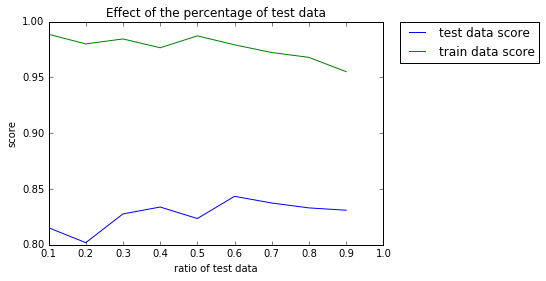

In [12]:
# different ratio values
ratio = np.arange(0.1,1.,0.1)
tr_score = []
te_score = []

for i in  np.arange(len(ratio)):
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio[i], random_state=4)  
    clf = RandomForestClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    print("ratio = {ind}, train data score = {tr_s}, test data score = {te_s}".format(ind=ratio[i],tr_s=tr_score[i],te_s=te_score[i]))

# plot results
plt.figure()
plt.title("Effect of the percentage of test data")
plt.plot(ratio, te_score, label="test data score")
plt.plot(ratio, tr_score, label="train data score")
plt.xlabel('ratio of test data')
plt.ylabel('score' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We will now perform the cross-validation to mitigate better the overfitting in our model.

In [13]:
# first try
clf = RandomForestClassifier()
scores = cross_val_score(clf, data_x, data_y, cv=10, scoring='accuracy')

print(scores)
print(scores.mean())

[ 0.82278481  0.84713376  0.81528662  0.83974359  0.8525641   0.83333333
  0.83333333  0.87820513  0.83333333  0.83974359]
0.839546160255


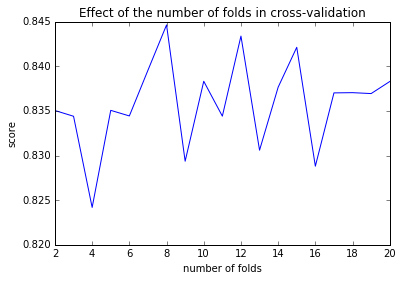

In [19]:
# using different values of folds
folds = np.arange(2,21,1)
cv_score = []
ratio = []

for i in  np.arange(len(folds)):
    ratio = np.r_[ratio,(1/folds[i])]
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, data_x, data_y, cv=folds[i], scoring='accuracy')
    cv_score = np.r_[cv_score,scores.mean()]

# plot results
plt.figure()
plt.title("Effect of the number of folds in cross-validation")
plt.plot(folds, cv_score)
plt.xlabel('number of folds')
plt.ylabel('score' )
plt.show()

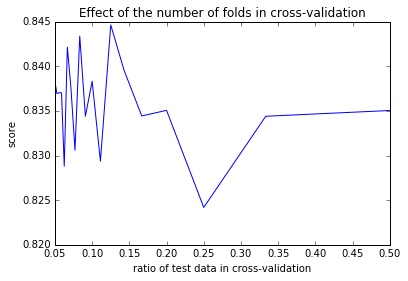

In [20]:
# plot results
plt.figure()
plt.title("Effect of the number of folds in cross-validation")
plt.plot(ratio, cv_score)
plt.xlabel('ratio of test data in cross-validation')
plt.ylabel('score' )
plt.show()

For the rest of the homework , we are going to use the ratio 0.33 for simple splitting tests and 15 folds in cross-validation.

In [21]:
ratio = 0.33
folds = 15

### Effect of the Classifier's parameters

We will now show how different parameters passed to the Classifier affect the overfitting issue. 

#### 1. number of estimators

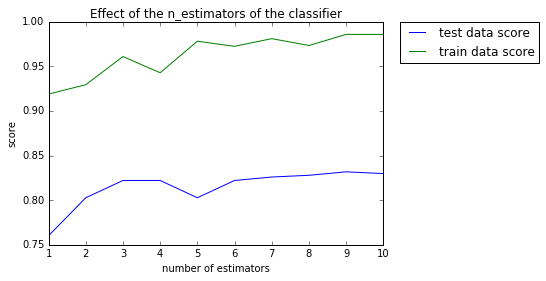

In [22]:
# different values of n_estimators
n = np.arange(1,11,1)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)
tr_score = []
te_score = []


for i in  np.arange(len(n)):
    clf = RandomForestClassifier(n_estimators = n[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]

# plot results
plt.figure()
plt.title("Effect of the n_estimators of the classifier")
plt.plot(n, te_score, label="test data score")
plt.plot(n, tr_score, label="train data score")
plt.xlabel('number of estimators')
plt.ylabel('score' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

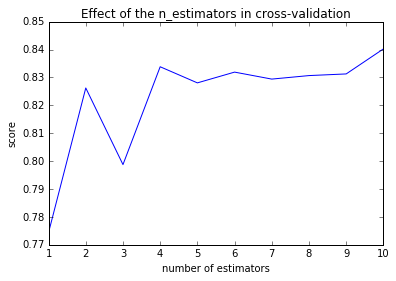

In [23]:
# using cross validation
cv_score = []
for i in  np.arange(len(n)):
    clf = RandomForestClassifier(n_estimators = n[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]

# plot results
plt.figure()
plt.title("Effect of the n_estimators in cross-validation")
plt.plot(n, cv_score)
plt.xlabel('number of estimators')
plt.ylabel('score' )
plt.show()

For the rest of the HW, we will use 6 estimators.

In [24]:
n = 6

#### 2. minimum of samples required to split the data

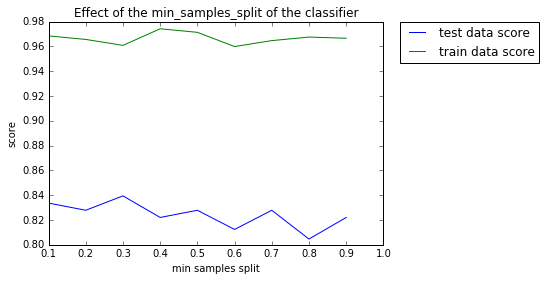

In [30]:
#min_samples_split
nss = np.arange(0.1,1.,0.1)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)    
tr_score = []
te_score = []

for i in  np.arange(len(nss)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    
# plot results
plt.figure()
plt.title("Effect of the min_samples_split of the classifier")
plt.plot(nss, te_score, label="test data score")
plt.plot(nss, tr_score, label="train data score")
plt.xlabel('min samples split')
plt.ylabel('score' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

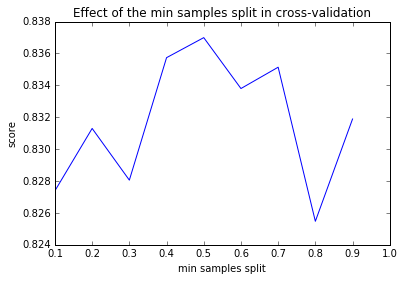

In [31]:
# using cross validation
cv_score = []

for i in  np.arange(len(nss)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]

# plot results
plt.figure()
plt.title("Effect of the min samples split in cross-validation")
plt.plot(nss, cv_score)
plt.xlabel('min samples split')
plt.ylabel('score' )
plt.show()

For the rest of the HW, we will require a percentage of 0.4 to split the data in the classifier.

In [32]:
nss = 0.4

#### 3. minimum of samples in a leaf

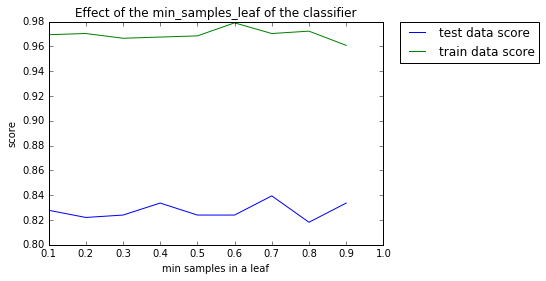

In [33]:
#min_samples_leaf
nsl = np.arange(0.1,1.,0.1)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)   
tr_score = []
te_score = []

for i in  np.arange(len(nsl)):
    clf = RandomForestClassifier(n_estimators = n, min_samples_split = nss ,min_samples_leaf = nsl[i])
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tr_pred = clf.predict(X_train)
    tr_score = np.r_[tr_score,metrics.accuracy_score(y_train, tr_pred)]
    te_score = np.r_[te_score,metrics.accuracy_score(y_test, y_pred)]
    
# plot results
plt.figure()
plt.title("Effect of the min_samples_leaf of the classifier")
plt.plot(nsl, te_score, label="test data score")
plt.plot(nsl, tr_score, label="train data score")
plt.xlabel('min samples in a leaf')
plt.ylabel('score' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

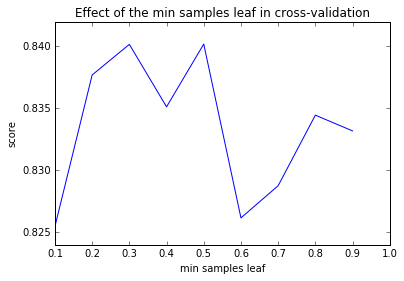

In [34]:
# using cross validation
cv_score = []
for i in  np.arange(len(nsl)):
    clf = RandomForestClassifier(n_estimators = n,min_samples_split = nss,min_samples_leaf = nsl[i])
    scores = cross_val_score(clf, data_x, data_y, cv=folds, scoring='accuracy')
    cv_score = np.r_[cv_score, scores.mean()]

# plot results
plt.figure()
plt.title("Effect of the min samples leaf in cross-validation")
plt.plot(nsl, cv_score)
plt.xlabel('min samples leaf')
plt.ylabel('score' )
plt.show()

For the rest of the HW, we will require a percentage of 0.3 to form a leaf in the classifier.

In [35]:
nsf = 0.3

### Feature's importance

Now that we assessed our model, we will inspect the feature importances attribute and discuss the obtained results. 

In [49]:
# building the classifier
clf = RandomForestClassifier(n_estimators = n,min_samples_split = nss,min_samples_leaf = nsf)
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=ratio, random_state=4)
# fitting the model
clf = clf.fit(X_train, y_train)
# score
y_pred = clf.predict(X_test)
print("score = {s}".format(s=metrics.accuracy_score(y_test, y_pred)))

# Feature importances
clf.feature_importances_

score = 0.816247582205029


array([ 0.02266143,  0.06299122,  0.07178005,  0.07338108,  0.07262676,
        0.06049705,  0.0857304 ,  0.06053146,  0.10847121,  0.03767339,
        0.0907253 ,  0.03167419,  0.04894987,  0.11347626,  0.05883034])

In [50]:
# creating the list of columns
dcopy_x = data.copy()
dcopy_x.drop(['Unnamed: 0', 'playerShort', 'birthday', 'black'], axis=1, inplace=True)

l_columns = list(dcopy_x.columns.values)
l_columns

['yellowReds',
 'goals',
 'ties',
 'leagueCountry',
 'defeats',
 'weight',
 'victories',
 'height',
 'meanExp',
 'yellowCards',
 'games',
 'redCards',
 'position',
 'meanIAT',
 'club']

Feature ranking:
1. feature 13 meanIAT (0.113476)
2. feature 8 meanExp (0.108471)
3. feature 10 games (0.090725)
4. feature 6 victories (0.085730)
5. feature 3 leagueCountry (0.073381)
6. feature 4 defeats (0.072627)
7. feature 2 ties (0.071780)
8. feature 1 goals (0.062991)
9. feature 7 height (0.060531)
10. feature 5 weight (0.060497)
11. feature 14 club (0.058830)
12. feature 12 position (0.048950)
13. feature 9 yellowCards (0.037673)
14. feature 11 redCards (0.031674)
15. feature 0 yellowReds (0.022661)


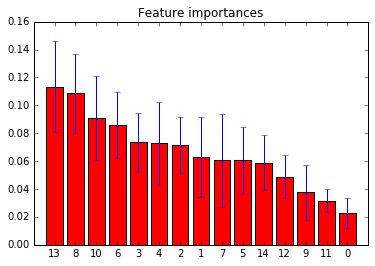

In [51]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], l_columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_x.shape[1]), indices)
plt.xlim([-1, data_x.shape[1]])
plt.show()

    - meanIAT and meanExp are the more relevant.
    - yellowReds and redCards are less relevant.

We will now see if, with different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), wa can obtain a substantially different feature importances attribute

In [52]:
# dropping irrelevant features (yellowReds and redCards)
dcopy_x = data.copy()
dcopy_x.drop(['Unnamed: 0', 'playerShort', 'birthday', 'black','yellowReds','redCards'], axis=1, inplace=True)

l_columns = list(dcopy_x.columns.values)
l_columns

['goals',
 'ties',
 'leagueCountry',
 'defeats',
 'weight',
 'victories',
 'height',
 'meanExp',
 'yellowCards',
 'games',
 'position',
 'meanIAT',
 'club']

Feature ranking:
1. feature 11 meanIAT (0.129794)
2. feature 7 meanExp (0.122365)
3. feature 1 ties (0.084187)
4. feature 0 goals (0.083631)
5. feature 8 yellowCards (0.080027)
6. feature 3 defeats (0.075963)
7. feature 12 club (0.075419)
8. feature 9 games (0.071980)
9. feature 5 victories (0.066969)
10. feature 4 weight (0.061797)
11. feature 6 height (0.053097)
12. feature 2 leagueCountry (0.052162)
13. feature 10 position (0.042610)


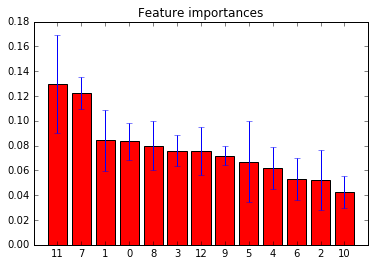

In [53]:
data2_x = dcopy_x.as_matrix()
# Build classifier
clf = RandomForestClassifier(n_estimators = n,min_samples_split = nss,min_samples_leaf = nsf)
clf = clf.fit(data2_x, data_y)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data2_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],l_columns[indices[f]] , importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data2_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data2_x.shape[1]), indices)
plt.xlim([-1, data2_x.shape[1]])
plt.show()

    - meanIAT and meanExp are still the more relevant.
Meanwhile , there is a difference in the ranking among the other features.

### BONUS: 

plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

### Answer : 
This work has been done in the "Effect of the Classifier's parameters" part above. The resulting set of parameters leading to high bias was (n_estimators = 6, min_samples_split = 4 , min_samples_leaf = )